In [1]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler, OneHotEncoder
from pyspark.sql.functions import col, explode, trim, lower, regexp_replace, expr
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
import seaborn as sns 
import matplotlib.pyplot as plt
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/16 17:03:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.option('escape','"').csv('kickstarter_cleaned.csv', header=True, inferSchema=True, mode="DROPMALFORMED")

# Correlation between variables

### Indexing of categorical variables

Remove rows with Null values on goal or pledged, otherwise the standard scaler fails.

In [4]:
df_corr = df.drop("name")
df_corr.where(df_corr.pledged.isNull()).show() 
df_corr = df_corr.filter(df_corr.pledged.isNull() != True)

+--------+-------------+--------+-----+-------+-------+----+----+-----+-----------+-------------+---------------+---------+---------+
|category|main_category|currency|state|backers|pledged|goal|year|month|day_of_week|time_interval|length_of_title|use_of_?!|continent|
+--------+-------------+--------+-----+-------+-------+----+----+-----+-----------+-------------+---------------+---------+---------+
|    NULL|         NULL|    NULL| NULL|   NULL|   NULL|NULL|NULL| NULL|       NULL|         NULL|           NULL|     NULL|     NULL|
+--------+-------------+--------+-----+-------+-------+----+----+-----+-----------+-------------+---------------+---------+---------+



In [5]:
# Create indexes for the categorical columns.
categorical_cols = ["category", "main_category", "currency", "state", "continent"]  
stand_cols = ["goal", "pledged"]  

# Indexing the categorical columns
indexers = [StringIndexer(inputCol = col, outputCol = col + "_index", handleInvalid = "skip") for col in categorical_cols]

# Adding indexes of categorical columns to the dataframe
pipeline_indexes = Pipeline(stages = indexers)
model_indexes = pipeline_indexes.fit(df_corr)
cat_indexes_df = model_indexes.transform(df_corr)

### Standardization

The attributes to be standardized are: goal, pledged.

In [6]:
# Select the columns that won't be standardize.
numerical_cols = [col for col in df_corr.columns if col not in categorical_cols + stand_cols]
cols_to_keep_unscaled = [col + "_index" for col in categorical_cols] + numerical_cols

# Standardize goal and pledged.
scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures")
assembler_scaler = VectorAssembler().setInputCols(stand_cols).setOutputCol("features")
df_scaled = assembler_scaler.transform(cat_indexes_df)
scaler_model = scaler.fit(df_scaled.select("features"))
df_scaled = scaler_model.transform(df_scaled)

In [7]:
# Rename the column 'use_of_?!' because it cause syntax problems when grouping the standardize columns with the others.
df_scaled = df_scaled.withColumnRenamed('use_of_?!', 'use_of_symbols')

In [8]:
# Update the dataframe leaving only the indexed variables, the numerical and the standardize ones.
numerical_cols = ['backers', 'year', 'month', 'day_of_week', 'time_interval', 'length_of_title', 'use_of_symbols']

cols_to_keep_unscaled = [col + "_index" for col in categorical_cols] + numerical_cols

def extract(row):
    return (row.category_index, row.main_category_index, row.currency_index, row.state_index, row.continent_index, \
            row.backers, row.year, row.month, row.day_of_week, row.time_interval, row.length_of_title, row.use_of_symbols) \
            + tuple(row.scaledFeatures.toArray().tolist())

df_scaled = df_scaled.select(*cols_to_keep_unscaled, "scaledFeatures").rdd.map(extract).toDF(cols_to_keep_unscaled + stand_cols)

### Correlation Matrices

In [9]:
# Create a vector containing all the variables of the dataframe previously created.
assembler_corr = VectorAssembler().setInputCols(df_scaled.columns).setOutputCol("features") 
pipeline_corr = Pipeline(stages = [assembler_corr])
model_corr = pipeline_corr.fit(df_scaled)

# create dataframe to find the correlation between variables
df_corr = df_scaled
df_corr = model_corr.transform(df_corr)

In [10]:
# Compute the Pearson and Spearman coefficient
linear_corr_matrix = Correlation.corr(df_corr,"features", method = 'pearson')
spearman_corr_matrix = Correlation.corr(df_corr,"features", method = 'spearman')

# Organize the Pearson coefficients in a matrix
linear_corr_matrix = linear_corr_matrix.collect()[0][0] 
linear_corr_matrix_df = pd.DataFrame(linear_corr_matrix.toArray(), index = df_corr.columns[:-1], columns = df_corr.columns[:-1])

# Rename the columns and indexes of the correlation dataframe
linear_corr_matrix_df = linear_corr_matrix_df.rename(columns = {'category_index': 'category', 'main_category_index': 'main_category', 'currency_index': 'currency', 'state_index': 'state', 'continent_index': 'continent'}, 
                             index = {'category_index': 'category', 'main_category_index': 'main_category', 'currency_index': 'currency', 'state_index': 'state', 'continent_index': 'continent'})

23/12/16 17:06:52 WARN Executor: Managed memory leak detected; size = 38213306 bytes, task 0.0 in stage 28.0 (TID 22)
23/12/16 17:06:55 WARN Executor: Managed memory leak detected; size = 38213306 bytes, task 0.0 in stage 34.0 (TID 24)


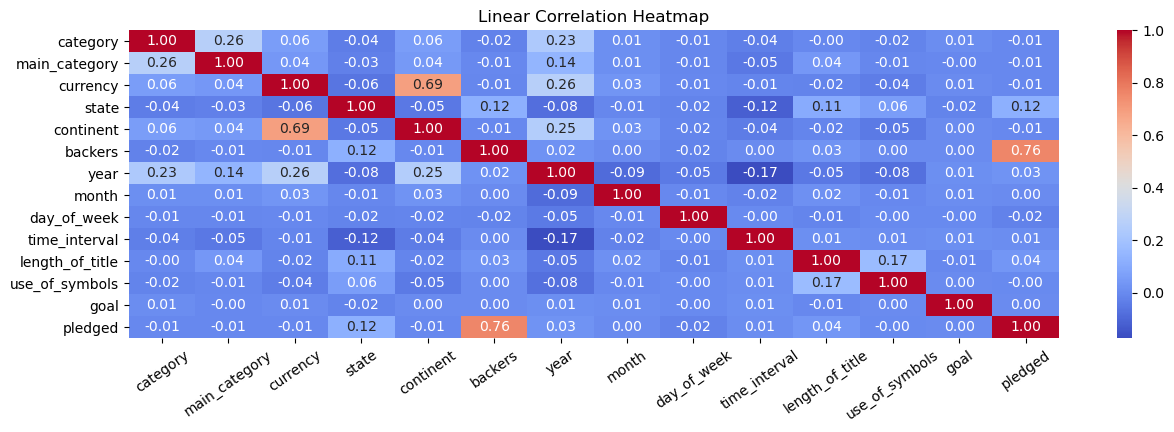

<Figure size 640x480 with 0 Axes>

In [11]:
# Plot the heat map of the resulting Pearson correlation matrix
plt.figure(figsize = (15,4))
sns.heatmap(linear_corr_matrix_df, annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title("Linear Correlation Heatmap")
plt.xticks(rotation = 35)
plt.show()
plt.savefig('linear_corr.png')

In [12]:
# Create the Spearman matrix correlation
spearman_corr_matrix = spearman_corr_matrix.collect()[0][0] 
spearman_corr_matrix_df = pd.DataFrame(spearman_corr_matrix.toArray(), index = df_corr.columns[:-1], columns = df_corr.columns[:-1])

# Rename the columns and the indexes of the matrix
spearman_corr_matrix_df = spearman_corr_matrix_df.rename(columns = {'category_index': 'category', 'main_category_index': 'main_category', 'currency_index': 'currency', 'state_index': 'state', 'continent_index': 'continent'}, 
                             index = {'category_index': 'category', 'main_category_index': 'main_category', 'currency_index': 'currency', 'state_index': 'state', 'continent_index': 'continent'})

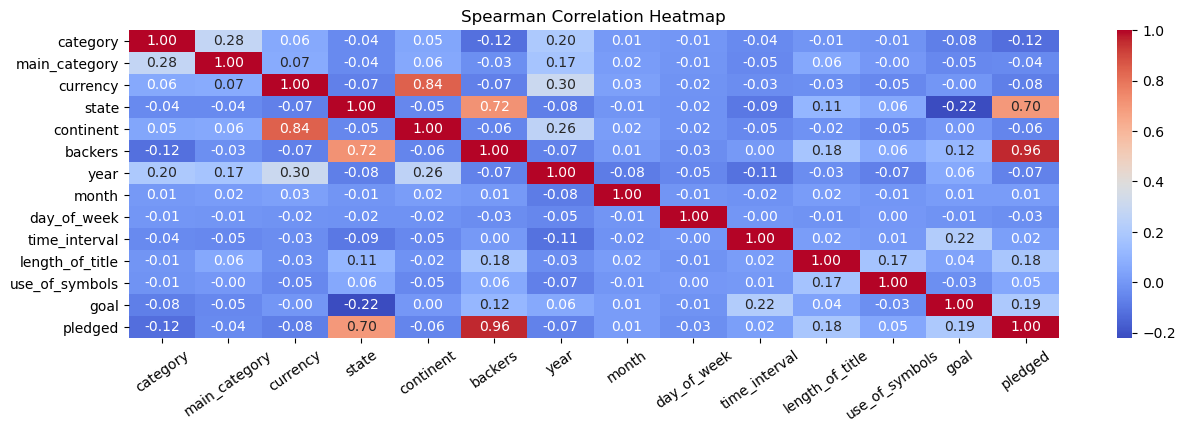

<Figure size 640x480 with 0 Axes>

In [13]:
# Plot the heat map of the resulting Spearman correlation matrix
plt.figure(figsize = (15,4))
sns.heatmap(spearman_corr_matrix_df, annot = True, cmap = 'coolwarm', fmt=".2f")
plt.title("Spearman Correlation Heatmap")
plt.xticks(rotation = 35)
plt.show()
plt.savefig('spearman_corr.png')

Since pledged and backers, and continent and currency are highly correlated, they cannot be considered together as independent variables for the linear regression model. So, to train the linear regressor, we will keep pledged and currency. Notice as well that pledged and backers show a high non-linear correlation between them and also with the target variable state. This means that for further analysis will be better to remove both of them.


# Linear Regression

In [14]:
df_regression = cat_indexes_df.select("*")
df_regression.drop('continent', 'backers', 'continent_index')
df_regression = df_regression.withColumnRenamed('use_of_?!', 'use_of_symbols')

In [15]:
train_df, test_df = df_regression.randomSplit([0.7, 0.3])

In [16]:
# Select the columns that won't be standardize.

stand_cols = ["goal", "pledged"]  

# Standardize goal and pledged.
scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures")
assembler_scaler = VectorAssembler().setInputCols(stand_cols).setOutputCol("features")
train_df_assembled = assembler_scaler.transform(train_df)
test_df_assembled = assembler_scaler.transform(test_df)

scaler_model = scaler.fit(train_df_assembled.select("features"))
train_df_scaled = scaler_model.transform(train_df_assembled)
test_df_scaled = scaler_model.transform(test_df_assembled)

In [17]:
cols_to_keep_unscaled = ['category_index', 'main_category_index', 'currency_index', 'state_index', 'year', 'month', 'day_of_week', 'time_interval', 'length_of_title', 'use_of_symbols']

In [18]:
# Function that extracts every component of an assembled vector
def extract(row):
    return (row.category_index, row.main_category_index, row.currency_index, row.state_index,\
            row.year, row.month, row.day_of_week, row.time_interval, row.length_of_title, row.use_of_symbols) \
            + tuple(row.scaledFeatures.toArray().tolist())

# Extract goal and pledged from the assembled vector and organized in the df as independent columns
train_df_scaled = train_df_scaled.select(*cols_to_keep_unscaled, "scaledFeatures").rdd.map(extract).toDF(cols_to_keep_unscaled + stand_cols)
trest_df_scaled = test_df_scaled.select(*cols_to_keep_unscaled, "scaledFeatures").rdd.map(extract).toDF(cols_to_keep_unscaled + stand_cols)

### One-hot encoding

In [19]:
var_to_hotencode = ["category_index", "main_category_index", "currency_index", "year", "month", "day_of_week", "use_of_symbols"]

# Check that the number of unique values of each categorical variable in the train and test sets coincide
for column in var_to_hotencode:
    print(f"Unique values in {column} - Training set: {train_df_scaled.select(column).distinct().count()}, Test set: {test_df_scaled.select(column).distinct().count()}")


Unique values in category_index - Training set: 159, Test set: 157


Unique values in main_category_index - Training set: 15, Test set: 15


Unique values in currency_index - Training set: 14, Test set: 14


Unique values in year - Training set: 9, Test set: 9


Unique values in month - Training set: 12, Test set: 12


Unique values in day_of_week - Training set: 7, Test set: 7


Unique values in use_of_symbols - Training set: 2, Test set: 2


In [20]:
from pyspark.sql.functions import when

# Assuming "default_category" is a category that can be used for filling missing values
default_category = -1

# Create a default category used for filling missing values in case of missing unique values in the test set.
# This avoids that the hot encoder fails.
for column in var_to_hotencode:
    test_df_scaled = test_df_scaled.withColumn(column, when(test_df_scaled[column].isNull(), default_category).otherwise(test_df_scaled[column]))


In [21]:
# One-hot encoding
encoders = [OneHotEncoder(dropLast = False, inputCol = var, outputCol = "{0}_encoded".format(var), handleInvalid="keep") for var in var_to_hotencode]


# Assemble all the variables
assembler_ind_var = VectorAssembler(inputCols = [encoder.getOutputCol() for encoder in encoders] + ["time_interval", "length_of_title", "goal", 'pledged'], \
                                    outputCol = "ind_var")

# Add the assembled vector to dataframe that will be used for the regression
pipeline_hotencode = Pipeline(stages = encoders + [assembler_ind_var])
fit_hotencode = pipeline_hotencode.fit(train_df_scaled)
train_df_hotencode = fit_hotencode.transform(train_df_scaled)
test_df_hotencode = fit_hotencode.transform(test_df_scaled)

### Training

In [22]:
# Reduce the dataframe selecting only the columns needed for the regression, the vector of independent variables and the target varaible
train_df_regression = train_df_hotencode.select("ind_var", "state_index")

# Fit the multivariate linear regression model
regressor = LinearRegression(featuresCol = 'ind_var', labelCol = 'state_index')
regressor_model = regressor.fit(train_df_regression)
print("Intercept: " + str(regressor_model.intercept))

23/12/16 17:14:45 WARN Instrumentation: [cbc2e9a4] regParam is zero, which might cause numerical instability and overfitting.
23/12/16 17:15:07 WARN Instrumentation: [cbc2e9a4] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


Intercept: 0.48721887731046976


### Evaluation of the regressor

In [23]:
## Measure the performance model with the train dataset
trainingSummary = regressor_model.summary

# Use the model in the test dataset
test_df_regression = test_df_hotencode.select("ind_var", "state_index")
predictions = regressor_model.transform(test_df_regression)

# Set the threshold (adjust as needed)
threshold = 0.5

# Use the threshold to convert predicted probabilities to binary outcomes
binary_predictions = predictions.withColumn(
     "prediction_binary", expr(f"CAST(CASE WHEN prediction >= {threshold} THEN 1 ELSE 0 END AS DOUBLE)"))

In [24]:
# Measure the performance of the model
evaluator = RegressionEvaluator(labelCol = "state_index", predictionCol = "prediction_binary", metricName = "rmse")
rmse_test = evaluator.evaluate(binary_predictions.select('state_index', 'prediction_binary'))

evaluator_r2 = RegressionEvaluator(labelCol = "state_index", predictionCol = "prediction_binary", metricName = "r2")
r2_test = evaluator_r2.evaluate(binary_predictions)

print("Root Mean Squared Error (RMSE) on train data: {:.3f} \n Root Mean Squared Error (RMSE) on test data: {:.3f} \n".format(trainingSummary.rootMeanSquaredError, rmse_test))
print("R-squared (R2) on train data: {:.3f} \n R-squared (R2) on test data: {:.3f}".format(trainingSummary.r2, r2_test))

Root Mean Squared Error (RMSE) on train data: 0.455 
 Root Mean Squared Error (RMSE) on test data: 0.381 

R-squared (R2) on train data: 0.143 
 R-squared (R2) on test data: 0.399


### Feature importance

In [25]:
# Find the feature importance using the coefficients obtained from the model.
variables= ['pledged', 'time_interval', 'length_of_title', 'goal', 'category_index_encoded', 'main_category_index_encoded',
 'currency_index_encoded', 'year_encoded', 'month_encoded', 'day_of_week_encoded', 'use_of_symbols_encoded']

coefficients = regressor_model.coefficients

feature_importance = sorted(list(zip(variables, map(abs, coefficients))), key = lambda x: x[1], reverse = True)

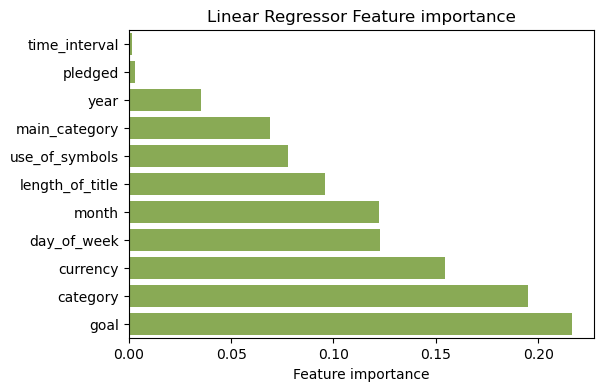

In [26]:
#Vector of variables and values of the feature importance
variables = [feature_importance[i][0] for i in range(len(feature_importance))]
variables = [word.replace('_index_encoded', '') for word in variables]
variables = [word.replace('_encoded', '') for word in variables]
variables.reverse()

values = [feature_importance[i][1] for i in range(len(feature_importance))]
values.reverse()

# Plot of the linear regressor feature importance
plt.figure(figsize = (6,4))
sns.barplot(x = values, y = variables, color = '#8cb847', orient = 'h')
plt.title("Linear Regressor Feature importance")
plt.xlabel('Feature importance')
plt.show()

#### Does our model improve using a regularization technique? 

Since the results of the previous regressor are not too good, let's train a new model with the following changes. The pledged variable will also be deleted it. We will use the Elastic Net regularization that combines Lasso and Ridge regularizations

In [27]:
# assemble all the variables
assembler_ind_var = VectorAssembler(inputCols = [encoder.getOutputCol() for encoder in encoders] + ["time_interval", "length_of_title", "goal"], \
                                    outputCol = "ind_var")

train_df_scaled_2 = train_df_scaled.select("*")
test_df_scaled_2 = test_df_scaled.select("*")

# Add the assembled vect
pipeline_hotencode = Pipeline(stages = encoders + [assembler_ind_var])
model_hotencode = pipeline_hotencode.fit(train_df_scaled_2)
train_df_hotencode_2 = model_hotencode.transform(train_df_scaled_2)
test_df_hotencode_2 = model_hotencode.transform(test_df_scaled_2)

# Reduce the dataframe selecting only the columns needed for the regression
train_df_regression_2 = train_df_hotencode_2.select("ind_var", "state_index")
test_df_regression_2 = test_df_hotencode_2.select("ind_var", "state_index")

# Fit the multivariate linear regression model
regressor_reg = LinearRegression(featuresCol = 'ind_var', labelCol = 'state_index', regParam=0.1, elasticNetParam=0.5)
regressor_model_reg = regressor_reg.fit(train_df_regression_2)
#print("Coefficients: " + str(regressor_model.coefficients))
print("Intercept: " + str(regressor_model_reg.intercept))

Intercept: 0.4246897451367286


In [28]:
# Measure the performance model with the train dataset
trainingSummary_r2 = regressor_model_reg.summary

# Use the model in the test dataset
predictions_2 = regressor_model_reg.transform(test_df_regression_2)

binary_predictions_2 = predictions_2.withColumn(
     "prediction_binary", expr(f"CAST(CASE WHEN prediction >= {threshold} THEN 1 ELSE 0 END AS DOUBLE)"))

# Measure the performance of the model
evaluator_rmse_2 = RegressionEvaluator(labelCol = "state_index", predictionCol = "prediction", metricName = "rmse")
rmse_test_2 = evaluator_rmse_2.evaluate(binary_predictions_2)

evaluator_r2_2 = RegressionEvaluator(labelCol = "state_index", predictionCol = "prediction", metricName = "r2")
r2_test_2 = evaluator_r2_2.evaluate(binary_predictions_2)
print("Root Mean Squared Error (RMSE) on train data: {:.3f} \n Root Mean Squared Error (RMSE) on test data: {:.3f}".format(trainingSummary_r2.rootMeanSquaredError, rmse_test_2))
print("R-squared (R2) on train data: {:.3f} \n R-squared (R2) on test data: {:.3f}".format(trainingSummary_r2.r2, r2_test_2))

Root Mean Squared Error (RMSE) on train data: 0.490 
 Root Mean Squared Error (RMSE) on test data: 0.490
R-squared (R2) on train data: 0.005 
 R-squared (R2) on test data: 0.005
